<h1 align="center"> Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods</h1>
<h2 align="center"> Is a real estate sell price good, fair, or above average?</h2>

### Background and Proposal

When you want to by a car, you go to [AutoTrader](https://www.autotrader.ca/) or [CarGuru](https://ca.cargurus.com/). One sweet thing about using such websites is that they tell you the car you are interested has a below-market price or above market price based on their own algorithms. 

However, when you looking for either renting or buying a real estate from websites such as [Centris](https://www.centris.ca/en/) or [DuProprio](https://duproprio.com/en), you won't be able to find neither if similar real estate exists somewhere else in the city nor if it's price is below market (a.k.a., a good deal).

Is such thing should be done? I certainly think so. One of my friends recently wants to buy a condomunium in Montreal. He told me it is exhausting to find an ideal condo to buy. Sometime the location is acceptable but the price is way above the budget, sometimes the price is fair but location isn't ideal. He literrally has to view all the available condos and compare them by heart to determine which one is the best.

My friend's experience has intrggered me to develop a tool that can:

1. find similar for sale real estate based on the one you are interested, and
2. build a price regression model and predict if the sale price is above or below the market.

This tool can help to fast locate other similar real estates once you have on in mind. It also sets a reference on price to help you determine which one is worth buying.

How am I going to do it? The first and foremost step is to find the for sale real estates. I intend to use web crawler to get data from [DuProprio](https://duproprio.com/en). The real estate data shall have the following information:

- address
- sale price
- number of rooms
- areas
- built year

Then I will use the address to extract the neighbourhood informaiton from [Foursquare](https://foursquare.com/city-guide). I will categorize the neighbourhood venues into several main categories such as:

- parks
- grocery stores
- schools
- clinic/hospital
- public transportation

All the data shall be ready by now. The tool will take one specific real estate as an input and find all similar ones by using segmentation and clustering technique. A price regression model is further developed within one cluster. Using the regression model to predict the price for all similar real estates will give reference on price. Finally, display all the candidates in ascending order of (actual price - predicted price).

### Data

I used a [web scrawler](https://github.com/Alcander-Z/MTL_house) to collect data about real estate for sale from [DuProprio](https://duproprio.com/en/search/list?search=true&regions%5B0%5D=6&is_for_sale=1&with_builders=1&parent=1&pageNumber=1&sort=-published_at). The raw data is saved as JSON file. It is available at [Here](https://github.com/Alcander-Z/Coursera_Capstone/blob/master/duproprio-20190517.json)

Let's load it and convert to pandas DataFrame.

In [1]:
import json
import pandas as pd

In [2]:
with open(r'duproprio-20190517.json', 'r') as f:
    jsf = json.load(f)
df = pd.DataFrame.from_dict(jsf)

Let's see the number of rows and columns of the dataframe

In [3]:
df.shape

(1099, 13)

Let's the column names

In [4]:
df.columns.values

array(['address', 'areas', 'backyard', 'bathrooms', 'bedrooms',
       'category', 'floor_if_condo', 'levels', 'municipal', 'ownership',
       'postalcode', 'price', 'year'], dtype=object)

There are 13 attributes (columns) of a real estate:

- address and postalcode shall be used to define neighbourhood;
- areas, bathrooms, bedrooms, years shall be used for the price regression model;

Let's further look into the 'category' column:

In [5]:
df.category.value_counts()

Condominium      517
New              110
2                 80
Duplex            72
Bungalow          72
Townhouse         63
Triplex           54
Semi-detached     39
Split             22
Quadruplex        19
Quintuplex        14
Commercial         8
Loft               6
6                  6
Penthouse          4
Storey             4
Residential        4
Raised             2
3                  2
Bi-generation      1
Name: category, dtype: int64

Category defines the type of a real estate. It is obvious that 'Condominium' is dominant in numbers among all. I will only use __condominium__ to continue the analysis.

In [6]:
subsets = ['price', 'address', 'category', 'year', 'bedrooms', 'bathrooms', 'areas', 'postalcode']
df.dropna(subset=subsets, axis=0, inplace=True)
df.drop(columns=['ownership', 'levels'], inplace=True)
condo = df[df.category=='Condominium'].reset_index(drop=True)
condo.head()

,address,areas,backyard,bathrooms,bedrooms,category,floor_if_condo,municipal,postalcode,price,year
0,"5985 Boyer, Rosemont / La Petite Patrie, QC","2,000 ft² (185.81 m²)",East,2.5,3.0,Condominium,1.0,394000.0,H2S 2H8,599000,1928
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC","1,100 ft² (102.19 m²)",None,1.5,2.0,Condominium,10.0,316600.0,H1H 0A1,349000,2006
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",911 ft² (84.63 m²),North-West,1.0,2.0,Condominium,3.0,207200.0,H1A 5R8,200000,1999
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",950 ft² (88.26 m²),South,1.0,2.0,Condominium,7.0,339500.0,H4C 0B8,415000,2011
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.4 m² (1 145.28 ft²),None,2.5,2.0,Condominium,1.0,350700.0,H2J 2W3,415000,2005


In [7]:
print("invalid backyard numbers: ", condo.backyard.isna().sum())
print("invalid municipal numbers: ", condo.municipal.isna().sum())

invalid backyard numbers:  231
invalid municipal numbers:  241


There are a few things shall be done before city segmentation and price regression modeling:

1. extract proper number of 'areas' from the string, (e.g., use $m^2$ as area unit);
2. add neighbourhood information for each condo;
3. use Foursquare to get venue information for each neighbourhood;
4. drop category;
5. drop backyard/municipal since nearly half of them are None.

In [8]:
condo.to_csv('condo_montreal.csv')

To download the dataset, [click here](https://github.com/Alcander-Z/Coursera_Capstone/blob/master/MTL_Condominium.csv)

### Methodology

#### extract area in $m^2$

In [9]:
import re
def get_area(string):
    """
    string format is either:
        xxxx ft^2 (xxxx m^2)
    or:
        xxx m^2 (xxxx ft^2)
    """
    unit = u'm\u00B2'
    pattern = '\d*\.?\d+' + ' ' + unit
    match = re.findall(pattern, string)
    try:
        return match[0].split()[0]
    except:
        return None

In [10]:
area = list(map(get_area, condo.areas))
condo.areas = area
condo.dropna(axis=0, subset=['areas'], inplace=True)
condo.areas.astype('float')
condo.head()

,address,areas,backyard,bathrooms,bedrooms,category,floor_if_condo,municipal,postalcode,price,year
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",185.81,East,2.5,3.0,Condominium,1.0,394000.0,H2S 2H8,599000,1928
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",102.19,None,1.5,2.0,Condominium,10.0,316600.0,H1H 0A1,349000,2006
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",84.63,North-West,1.0,2.0,Condominium,3.0,207200.0,H1A 5R8,200000,1999
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",88.26,South,1.0,2.0,Condominium,7.0,339500.0,H4C 0B8,415000,2011
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.4,None,2.5,2.0,Condominium,1.0,350700.0,H2J 2W3,415000,2005


#### drop category, backyard, municipal, floor_if_condo

In [11]:
condo.drop(columns=['backyard', 'category', 'floor_if_condo', 'municipal'], inplace=True)

#### neighbourhood is defined by the first 3 postalcode

postal code - borough map is crawled from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H). It is stored in a json file, with key of first 3 postalcode and value of neighbourhood name (e.g., "H1A": "Pointe-aux-Trembles")

In [12]:
with open(r'mtl_postalcode.json', 'r') as f:
    borough = json.load(f)

In [13]:
def get_borough(postal):
    postal = postal.strip()
    key = postal[:3]
    return borough.get(key, None)

In [16]:
condo['borough'] = list(map(get_borough, condo.postalcode))

In [17]:
condo.dropna(axis=0, subset=['borough'], inplace=True)
condo.reset_index(drop=True, inplace=True)
condo.head()

,address,areas,bathrooms,bedrooms,postalcode,price,year,borough
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",185.81,2.5,3.0,H2S 2H8,599000,1928,Petite-Patrie
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",102.19,1.5,2.0,H1H 0A1,349000,2006,Montréal-Nord
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",84.63,1.0,2.0,H1A 5R8,200000,1999,Pointe-aux-Trembles
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",88.26,1.0,2.0,H4C 0B8,415000,2011,Saint-Henri
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.4,2.5,2.0,H2J 2W3,415000,2005,Plateau Mont-Royal


Let's simply review some aggregated info by borough

In [31]:
condo.head()

,address,areas,bathrooms,bedrooms,postalcode,price,year,borough
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",185.81,2.5,3.0,H2S 2H8,599000,1928,Petite-Patrie
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",102.19,1.5,2.0,H1H 0A1,349000,2006,Montréal-Nord
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",84.63,1.0,2.0,H1A 5R8,200000,1999,Pointe-aux-Trembles
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",88.26,1.0,2.0,H4C 0B8,415000,2011,Saint-Henri
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.4,2.5,2.0,H2J 2W3,415000,2005,Plateau Mont-Royal


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

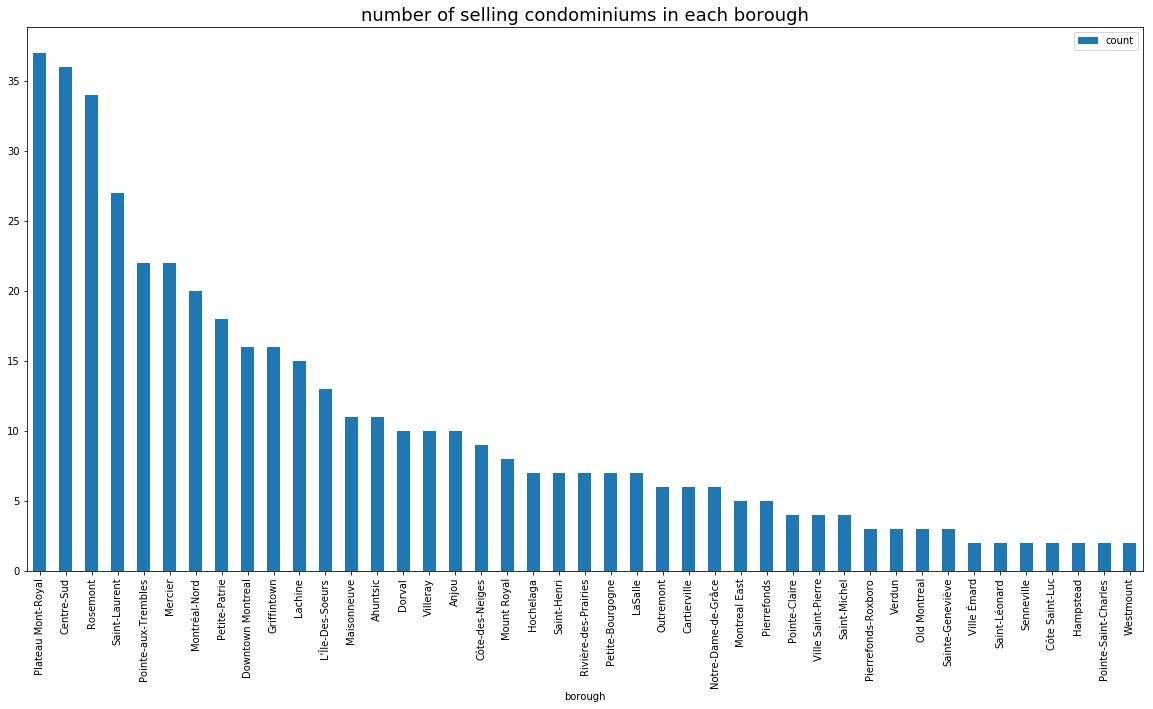

In [42]:
condo_borough_count = condo[['address', 'borough']].groupby('borough').count().sort_values(by='address', ascending=False).rename({'address':'count'},axis='columns')
fig, ax = plt.subplots(1,1, figsize=(20,10))
condo_borough_count.plot.bar(ax=ax)
ax.set_title('number of selling condominiums in each borough', fontsize=18)
plt.show()

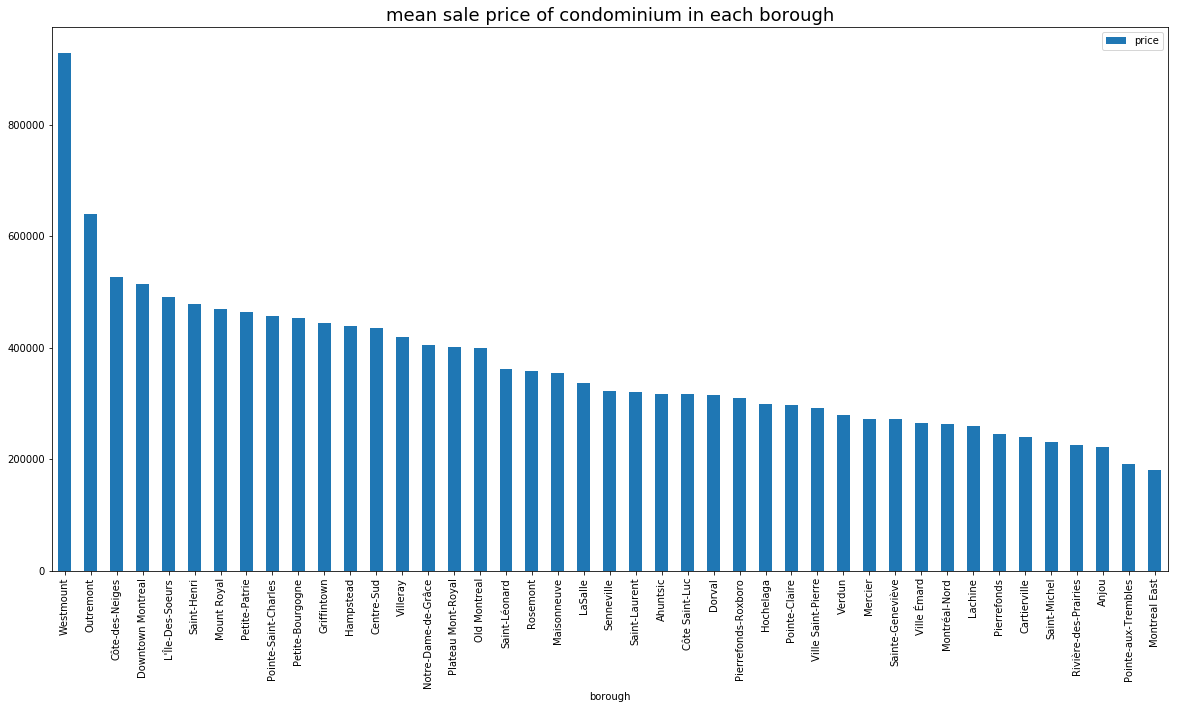

In [47]:
condo.price = condo.price.astype('float')
condo_borough_price = condo[['price', 'borough']].groupby('borough').mean().sort_values(by='price', ascending=False)
fig, ax = plt.subplots(1,1, figsize=(20,10))
condo_borough_price.plot.bar(ax=ax)
ax.set_title('mean sale price of condominium in each borough', fontsize=18)
plt.show()

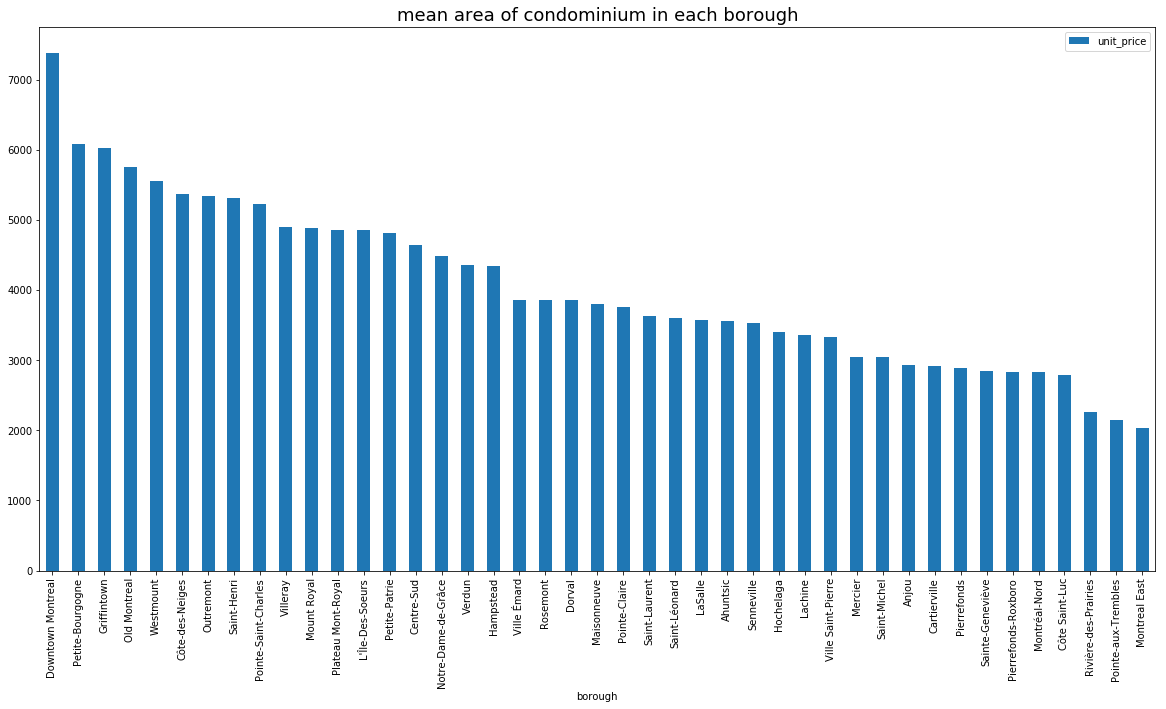

In [53]:
condo.areas = condo.areas.astype('float')
condo_borough_area = condo[['areas', 'borough']].groupby('borough').mean().sort_values(by='areas', ascending=False)
condo_borough_price_area = condo_borough_area.merge(condo_borough_price, how='inner', left_index=True, right_index=True)
condo_borough_price_area['unit_price'] = condo_borough_price_area['price'] / condo_borough_price_area['areas']
condo_borough_price_area.sort_values(by='unit_price', ascending=False, inplace=True)
fig, ax = plt.subplots(1,1, figsize=(20,10))
condo_borough_price_area.plot.bar(y='unit_price', ax=ax)
ax.set_title('mean area of condominium in each borough', fontsize=18)
plt.show()

Montreal has 123 neighbourhoods in total and 43 of them have condos for sale; __Plateau Mont-Royal__, __Centre-Sud__, and __Rosemont__ are top three neighbourhoods in the number of condos for sale; though __Westmount__ has only two selling condos, their average sale price is much higher than the price of condos in other neighbourhoods; __Downtown Montreal__ has the most expensive condo for sale in terms of average price per square meter.

#### Google Geolocation API for lat/lng of each condo

In [56]:
import googlemaps
import googlemaps_secret
import os

API_KEY = os.getenv('GOOGLE_API')
GMAPS = googlemaps.Client(key=API_KEY)

def addr2ll(address):
    result = GMAPS.geocode(address)
    if result:
        return result[0]['geometry']['location']
    else:
        return None

Test the function addr2ll() before batching processing

In [57]:
addr2ll(condo.loc[0, 'address'])

{'lat': 45.5354462, 'lng': -73.5981753}

In [72]:
from time import sleep

lat = []
lng = []
for i in range(condo.index.size):
    latlng = addr2ll(condo.loc[i, 'address'])
    if latlng:
        lat.append(latlng['lat'])
        lng.append(latlng['lng'])
    else:
        lat.append(None)
        lng.append(None)
    sleep(0.1)

In [73]:
condo['lat'] = lat
condo['lng'] = lng
condo.dropna(axis=0, subset=['lat', 'lng'], inplace=True)
condo.reset_index(drop=True, inplace=True)
condo.head()

,address,areas,bathrooms,bedrooms,postalcode,price,year,borough,lat,lng
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",185.81,2.5,3.0,H2S 2H8,599000.0,1928,Petite-Patrie,45.535446,-73.598175
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",102.19,1.5,2.0,H1H 0A1,349000.0,2006,Montréal-Nord,45.591632,-73.650183
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",84.63,1.0,2.0,H1A 5R8,200000.0,1999,Pointe-aux-Trembles,45.675129,-73.501151
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",88.26,1.0,2.0,H4C 0B8,415000.0,2011,Saint-Henri,45.475026,-73.593663
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.40,2.5,2.0,H2J 2W3,415000.0,2005,Plateau Mont-Royal,45.529412,-73.590276


Now we are able to see those condos on a map. Let's take a look. 

In [76]:
import folium
import numpy as np
from IPython.display import IFrame

In [93]:
map_mtl = folium.Map(location=[45.5498, -73.6708], zoom_start=11)

for lat, lng, prc in zip(condo['lat'], condo['lng'], condo['price']):
    label = "${}".format(prc)
    abel = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mtl)
    
map_mtl.save('mtl_condo.html')

In [95]:
IFrame(src='./mtl_condo.html', width=800, height=600)